## 해상도 5, -20 ~ 20

### package 불러오기 (환경 설정)

In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import numpy as np

### 변수 설정

In [2]:
# 변수 설정
BATCH_SIZE = 40
BATCH_MOMENTM = 0.9
EPOCH = 5
MIN_ANGLE, MAX_ANGLE, RESOLUTION = -20, 20, 5
NUM_CLASS = (MAX_ANGLE-MIN_ANGLE) // RESOLUTION + 1

print(NUM_CLASS)

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

9


### 데이터 셋 및 모델 설정

#### 데이터 셋 설정

In [3]:
class RadarDataset(Dataset):
  def __init__(self, transform, data, label):
    super(RadarDataset, self).__init__()
    self.transform = transform
    self.label = self.transform(label)
    self.data = self.transform(data).type(torch.float)

  def __len__(self, ):
    return self.data.shape[0]

  def __getitem__(self, index):   
    return self.data[index], self.label[index]


#### 모델 설정

In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
    
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=BATCH_MOMENTM),
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=BATCH_MOMENTM),
            nn.ReLU())
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=BATCH_MOMENTM),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=BATCH_MOMENTM),
            nn.ReLU())
        
        self.fc1 = nn.Sequential(
            nn.Linear(4*4*256, 4096),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
                
        self.fc3 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.fc4 = nn.Sequential(
            nn.Linear(1024, NUM_CLASS),
            nn.ReLU()
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        
        return out

#### custom loss 설정

In [5]:
def calc_covmat(batch_size, n_antenna, y_pred):
    COV_Mat_gen = torch.zeros((batch_size, n_antenna, n_antenna), dtype=torch.complex64)
    steering_vec = torch.zeros((n_antenna, 1), dtype=torch.complex64)
    angle_range = torch.arange(MIN_ANGLE, MAX_ANGLE+1, RESOLUTION)  # -60 ~ 60 (121)
        
    for batch_idx in range(batch_size):
        for idx, angle in enumerate(angle_range):
            rad = torch.deg2rad(angle)
            for antenna_idx in range(n_antenna):
                steering_vec[antenna_idx] = torch.exp(1j * torch.pi * torch.sin(rad) * antenna_idx) # (4, 1)
            COV_Mat_gen[batch_idx] += y_pred[batch_idx, idx] * (steering_vec @ steering_vec.conj().transpose(1, 0))

    return COV_Mat_gen

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, y_pred, y_true):
        batch_size, n_channel, n_antenna, n_antenna = y_true.shape
        COV_Mat_gen = calc_covmat(batch_size, n_antenna, y_pred.cpu())
        pred = torch.triu(torch.angle(COV_Mat_gen)).to(device)
        
        return torch.sqrt(nn.functional.mse_loss(y_true[:, 2], pred))

### 데이터 불러오기 및 학습 형태로 전환

#### 데이터 불러오기

In [7]:
Rx_sig = np.load(f'./total_output_COV_{RESOLUTION}_{MAX_ANGLE}.npy')
angle  = np.load(f'./total_output_angle_{RESOLUTION}_{MAX_ANGLE}.npy')

train_size = round(Rx_sig.shape[0]*0.8)
print(train_size)

# import train data
x_train = np.array([[(np.real(Rxx)), (np.imag(Rxx)), ((np.angle(Rxx)))] for Rxx in Rx_sig[:train_size]])
y_train = angle[:train_size]

# import valid data
x_valid = np.array([[(np.real(Rxx)), (np.imag(Rxx)), ((np.angle(Rxx)))] for Rxx in Rx_sig[train_size:]])
y_valid = angle[train_size:]

# import test data
x_test = np.array([[(np.real(Rxx)), (np.imag(Rxx)), ((np.angle(Rxx)))] for Rxx in Rx_sig[train_size:]])
y_test = angle[train_size:]

# y_test size transition
test_size = len(y_test)                     # 총 크기
find_num = len(np.where(y_test[0]== 1)[0])  # 찾아야 하는 물체의 개수

y_test_tmp = np.zeros((y_test.shape[0], find_num))  

for idx, data in enumerate(y_test):
    y_test_tmp[idx] = np.where(data== 1)[0]

y_test = y_test_tmp

8000


#### 학습한 적합한 형태로 변환

In [8]:
train_set = RadarDataset(transform=torch.from_numpy, data=x_train, label=y_train)
valid_set = RadarDataset(transform=torch.from_numpy, data=x_valid, label=y_valid)
test_set = RadarDataset(transform=torch.from_numpy, data=x_test, label=y_test)

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle = True)
valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, shuffle = False)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle = False)

### 학습 준비 및 학습 

#### 학습 준비 - 모델 및 loss 함수와 opimizer 설정 

In [9]:
model = ConvNet().to(device)

criterion = CustomLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

#### 학습 

In [10]:
# Train the model
total_train_step = len(train_loader)
total_valid_step = len(valid_loader)

total_train_loss, total_valid_loss = [], []

for epoch in range(EPOCH):
    train_loss, val_loss = 0, 0
    train_tqdm = tqdm(train_loader, total=len(train_loader), leave=False)
     
    model.train()
    for i, (x_train, y_train) in enumerate(train_tqdm, 1):
        x_train = x_train.to(device)
        # y_train = y_train.to(device)
        
        outputs = model(x_train)
        loss = criterion(outputs, x_train)
        optimizer.zero_grad()
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
        
        train_tqdm.set_description(desc=f'Training Loss on Epoch [{epoch+1}/{EPOCH}]: {train_loss / i: .3f}')
        
    with torch.no_grad():
        for k, (x_valid, y_valid) in enumerate(valid_loader):  # data의 크기를 bath_size 만큼 나눈 것을 반복한다.
            x_valid = x_valid.to(device)
            # y_valid = y_valid.to(device)
            
            val_output = model.forward(x_valid)
            v_loss = criterion(outputs, x_valid)
            
            val_loss += v_loss.item()
    
    total_train_loss.append(train_loss/total_train_step)
    total_valid_loss.append(val_loss/total_valid_step)

    print (f'Epoch [{epoch+1}/{EPOCH}], Step [{i}/{total_train_step}], train Loss: {train_loss/total_train_step:.4f}, val Loss: {val_loss/total_valid_step:.4f}')

Epoch [1/5], Step [200/200], train Loss: 0.9577, val Loss: 1.1746


Epoch [2/5], Step [200/200], train Loss: 0.9120, val Loss: 1.1867


Epoch [3/5], Step [200/200], train Loss: 0.9264, val Loss: 1.1962


Epoch [4/5], Step [200/200], train Loss: 0.9222, val Loss: 1.1981


Epoch [5/5], Step [200/200], train Loss: 0.9154, val Loss: 1.2200


### 결과 확인 

#### 지표로 확인

In [14]:
def cal_mapping_val(pred, test):
    pred_list, test_list = list(pred), list(test)
    mapping_list, mapping_val = [], []
    
    for val_test in test_list:
        min_val = float('inf')
        
        for val_pred in pred_list:
            result = abs(val_test - val_pred)
            
            if result < min_val:
                min_val = result
                mapping_val = val_pred
                
        mapping_list.append(abs(val_test - mapping_val))
        pred_list.remove(mapping_val)
    
    return mapping_list

TOLERANCE_ANGLE = 1
TRAIN_CHOICE = True
# Test the model
model.eval()  # eval mode (batch norm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct, total = 0, 0

    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test
        outputs = model(x_test)
        
        # 총 물체 개수
        total += y_test.size(0) * find_num
        
        # 찾아야 하는 물체의 index 추출
        results = map(lambda matrix: torch.topk(matrix, k=find_num, largest=True), outputs) 
        predicted = torch.tensor([list(map(lambda x: x.item(), indices)) for _, indices in results]) 
        
        # 추정 알고리즘
        result = np.array(list((map(cal_mapping_val, predicted, y_test))))
        correct += (result <= TOLERANCE_ANGLE).sum()
 
    print('Test Accuracy of the model on the {} test images: {} %'.format(test_size, 100 * correct / total))
    
# Save the model checkpoint
if TRAIN_CHOICE is True:
    torch.save(model.state_dict(), f'./model_{RESOLUTION}_{MAX_ANGLE}.ckpt')

Test Accuracy of the model on the 2000 test images: 87.45 %


#### 데이터로 확인

In [15]:
angle_range = torch.arange(MIN_ANGLE, MAX_ANGLE+1, RESOLUTION)

model.eval()
with torch.no_grad():
    outputs = model(x_test)
    
results = map(lambda matrix: torch.topk(matrix.reshape(-1), k=find_num, largest=True), outputs) 
predicted = torch.tensor([list(map(lambda x: x.item(), indices)) for _, indices in results])
print(angle_range[predicted].T)

print()
print(angle_range[y_test.long()].T)

tensor([[ 20,   5, -10,  20,  20,   0, -20,   0,   0, -20,  20,   5, -20,  20,
           5,  20,   0, -10,   0,   0,  20, -20,  20,  15, -20,   5,   0,  20,
          20,  15,   0,   5,  20,  20,  20,  15, -20,   0, -20, -20],
        [ 15,  15,  -5,   5,   0,   5,   5,  -5,  -5,   5,   0,  15,   5,   0,
           0,   0, -20, -15,   5,  -5,  15,   5,   0,  20,   5,  15,  -5,   0,
         -15,  20,   5,  15,   5,   5,   0,  20, -15,  -5,  15,   0]])

tensor([[ 10,   5, -10,   5,   0,  -5, -15, -10, -15, -20,   0,   5, -15,   0,
           0, -10, -15, -15, -10,  -5,  10, -15, -10,  10, -20,   5,  -5,  -5,
         -15, -20, -10,   5,   5,   5,  -5, -20, -20, -10, -20, -20],
        [ 20,  10,  -5,  20,  20,   5,   5,   5,   0,   5,  20,  10,  10,  20,
          15,  15,   0,  -5,  10,   0,  20,  10,  15,  15,   5,  10,   0,  15,
          20,  15,  10,  10,  20,  20,  20,  15, -10,   0,  10,   0]])


#### loss로 확인

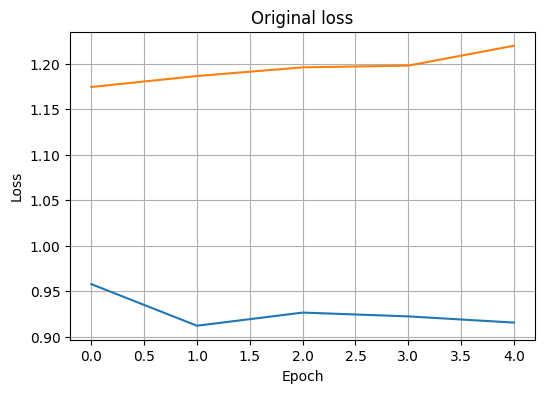

In [16]:
import matplotlib.pyplot as plt

## save fig
plt.figure(figsize=(6, 4))
plt.plot(list(range(EPOCH)), total_train_loss)
plt.plot(list(range(EPOCH)), total_valid_loss)
plt.title('Original loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()

## 실험 데이터가 잘 학습되는지 확인

### 학습된 모델 불러오기

In [17]:
model = ConvNet().to(device)
model.load_state_dict(torch.load(f'./model_{RESOLUTION}_{MAX_ANGLE}.ckpt'))

<All keys matched successfully>

### 실험 데이터 불러오기

In [19]:
Rx_sig = np.load(f'./test_output_COV_{RESOLUTION}_{MAX_ANGLE}.npy')
angle = np.load(f'./test_output_angle_{RESOLUTION}_{MAX_ANGLE}.npy')

x_test = np.array([[(np.real(Rxx)), (np.imag(Rxx)), ((np.angle(Rxx)))] for Rxx in Rx_sig])
x_test_torch= torch.from_numpy(x_test).type(torch.float).to(device)
y_test = angle.astype(int)

### 실험 데이터 검증

In [20]:
angle_range = torch.arange(MIN_ANGLE, MAX_ANGLE+1, RESOLUTION)

correct = 0
TOLERANCE_ANGLE = 0

model.eval() 
output = model(x_test_torch)
results = map(lambda matrix: torch.topk(matrix.reshape(-1), k=1, largest=True), output) 
predicted = torch.tensor([list(map(lambda x: x.item(), indices)) for _, indices in results])

pred_value = angle_range[predicted].T.numpy().reshape(-1)
real_value = y_test.T.reshape(-1)
print("percent".center(40, "-"))
result = np.array(list((map(cal_mapping_val, angle_range[predicted], y_test))))
correct += (result <= RESOLUTION * TOLERANCE_ANGLE).sum()
print(correct/len(real_value) * 100, end='\n\n')
# print(f'{(pred_value==real_value).sum()/len(real_value) * 100}%', end='\n\n')

print("data".center(40, "-"))
print("predict")
print(pred_value);print()
print("Real")
print(real_value)

----------------percent-----------------
0.0

------------------data------------------
predict
[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20  5 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20]

Real
[45 44 44 44 44 44 44 44 44 44 44 44 44 43 44 44 44  0 44 44 44 44 44 43
 44 44 44 44 44 43 44 44 44 44 45 44 44 44 44 45 44 44 43 43 45 44 44 44
 43 44 44 45 45 45 45 45 44 45 44 44 45 44 44 44 45 43 44 44  0  0 44 45
 45 44 44 44 44 44 44 44 44 44 44 44 44 45 44 44 45 43 45 44 43 44 45 43
 44 44 44 44]


## 기타

In [43]:
# def compensate_phase(matrix):
#     num_row, num_col = matrix.shape
#     Tolerence_interval = np.radians(5)
    
#     Trouble_value_min, Trouble_value_max = np.pi/2 - Tolerence_interval, np.pi/2
    
    
#     for idx_row in range(num_row):
#         for idx_col in range(num_col - 1):
#             diff_val = abs(matrix[idx_row, idx_col+1] - matrix[idx_row, idx_col])   # 두 연속된 값의 차
#             if Trouble_value_min < diff_val < Trouble_value_max:
#                 diff_interval_back = np.pi-abs(matrix[idx_row, idx_col+1])  # 해당 값과 180의 차 (뒤의 값 바꾸기)
#                 if diff_interval_back < Tolerence_interval:
#                     if (matrix[idx_row, idx_col+1] - matrix[idx_row, idx_col]) < 0:
#                       matrix[idx_row, idx_col+1] = np.pi
#                     else:
#                       matrix[idx_row, idx_col+1] = -np.pi
#     return matrix


# print(np.rad2deg(np.pi))

# tmp_matrix = np.array([[1.70411220e-20, -1.56466336e+00, -3.12932672e+00, -1.50231801e+00],
#                       [-1.59466336e+00,  2.05651625e-20,  1.59366766e+00, -3.14159265e+00],
#                       [-3.14159265e+00, -1.59366766e+00, -1.71187341e-19,  1.59231667e+00],
#                       [1.50231801e+00, -3.14159265e+00, -1.59231667e+00, -2.23292031e-19]])

# print(np.rad2deg(tmp_matrix).astype(int))
# print(np.rad2deg(compensate_phase(tmp_matrix)).astype(int))

In [ ]:
# def compensate_phase(matrix):
#     num_row, num_col = matrix.shape
#     Tolerence_interval = np.radians(5)
    
#     Trouble_value_min, Trouble_value_max = np.pi/2 - Tolerence_interval, np.pi/2
    
    
#     for idx_row in range(num_row):
#         for idx_col in range(num_col - 1):
#             diff_val = abs(matrix[idx_row, idx_col+1] - matrix[idx_row, idx_col])   # 두 연속된 값의 차
#             if Trouble_value_min < diff_val < Trouble_value_max:
#                 diff_interval_back = np.pi-abs(matrix[idx_row, idx_col+1])  # 해당 값과 180의 차 (뒤의 값 바꾸기)
#                 if diff_interval_back < Tolerence_interval:
#                     if (matrix[idx_row, idx_col+1] - matrix[idx_row, idx_col]) < 0:
#                       matrix[idx_row, idx_col+1] = np.pi
#                     else:
#                       matrix[idx_row, idx_col+1] = -np.pi
    # return matrix


# print(np.rad2deg(np.pi))

# tmp_matrix = np.array([[1.70411220e-20, -1.56466336e+00, -3.12932672e+00, -1.50231801e+00],
#                       [-1.59466336e+00,  2.05651625e-20,  1.59366766e+00, -3.14159265e+00],
#                       [-3.14159265e+00, -1.59366766e+00, -1.71187341e-19,  1.59231667e+00],
#                       [1.50231801e+00, -3.14159265e+00, -1.59231667e+00, -2.23292031e-19]])

# print(np.rad2deg(tmp_matrix).astype(int))
# print(np.rad2deg(compensate_phase(tmp_matrix)).astype(int))

In [26]:
# n_antenna = 4

# COV_Mat_gen = torch.zeros((n_antenna, n_antenna), dtype=torch.complex64)
# steering_vec = torch.zeros((n_antenna, 1), dtype=torch.complex64)
# angle_range = torch.arange(-60, 60+1, 1)  # -60 ~ 60 (121)
    
# y_pred = torch.zeros((len(angle_range)))
# y_pred[104] = 1

# for idx, angle in enumerate(angle_range):
#     rad = torch.deg2rad(angle)
#     for antenna_idx in range(n_antenna):
#         steering_vec[antenna_idx] = torch.exp(1j * torch.pi * torch.sin(rad) * antenna_idx) # (4, 1)
#     COV_Mat_gen += y_pred[idx] * (steering_vec @ steering_vec.conj().transpose(1, 0))

# print(torch.rad2deg(torch.angle(COV_Mat_gen)).type(torch.int32))

tensor([[   0, -125,  109,  -15],
        [ 125,    0, -125,  109],
        [-109,  125,    0, -125],
        [  15, -109,  125,    0]], dtype=torch.int32)
